# CH222

# Studying the solvation shell of ions via Molecular Dynamics Simulations

In this computational experiment you will use **molecular dynamics simulations** to investigate the solvation shell of ions at the atomistic level. For this computer experiment the ions and the solvent particles will be represented by relatively simple models (more on that later), and you will examine how the size of the cation and the temperature effect the structure of the solvation shell.

You will use the Python-based Jupyter Notebook framework, leveraging Statistical Mechanics to compute structural features of this system.

This notebook outlines how to set up the MD simulation using the HOOMD-blue simulation package, and some tips on using the Atomic Simulation Environment (ASE) for handling atomic configurations.

You can find further help, features and options on the Manual pages:  
[HOOMD-blue page](https://hoomd-blue.readthedocs.io/en/stable/index.html)  
[ASE page](https://wiki.fysik.dtu.dk/ase/index.html)

**IMPORTANT!!!** Use **Google Chrome** to work on the notebook instead of using Microsoft Explorer. The latter handles the visualisation package incorrectly.

### Content ###
1. Import necessary libraries and initialise HOOMD
2. Set up the system - initial structure, number of atoms
3. Define interaction between particles - binary Lennard-Jones
4. Set up the MD simulation and the ensemble - set the integrator, temperature, pressure
5. Set the output format - output file and logged quantities
6. Perform the simulation - run()
7. Saving the atomic coordinates and visualising the system 
8. Analysing results
9. Minimal working example

## 1. Import necessary libraries and initialise HOOMD

Import the hoomd python package and the md component we will use to perform MD simulations.

In [1]:
import hoomd
import hoomd.md

We need to initialize the execution context to control where HOOMD will execute the simulation. We will run the simulations on the CPU (HOOMD also allows options for GPU, but we won't use them).

In [2]:
hoomd.context.initialize('--mode=cpu');

HOOMD-blue v2.8.0-2-gff981a78f DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 
Compiled: 15/11/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


Import some further python packages we will need for analysing and visualising simulations results.

In [3]:
import numpy as np
from matplotlib import pyplot 
import ase # Atomic simulation environment
import ase.io
from ase.visualize import view
#packages necessary to visualise the trajectories
import pytraj as pt 
import nglview as nv

_ColormakerRegistry()

## 2. Create initial configuration

First we need to create the **inital configuration** for the simulation to start from: 

- size of the simulation box
- number of atoms in the system
- position of the atoms (coordinates)

We define our simulation system as the following: we create an initial smaller cell, than we will replicate this cell in each Cartesian direction (7 times) to create our actual simulation box (containing 686 atoms). In the initial small cell you can set the number and type of atoms, shape and size of the cell...etc. 
(Note: You can define the system only once, thus you can execute the code cell below only once. If you want to experiment with different setups, you need to restart the kernel or initialize the hoomd.context again!)

In [4]:
boxL=10.0
N_solvent=70

position=[]
type_name=[]
charge=[]
mass=[]

#Add solvent particles
for i in range(N_solvent):
    position.append(np.random.rand(3)*boxL)
    type_name.append('Solvent')
    charge.append(0.0)
    mass.append(1.0)

#Add one cation
position.append([0.0, 0.0, 0.0])
type_name.append('Cation')
charge.append(1.0)
mass.append(1.0)
    
#Add one anion    
position.append([2.0, 2.0, 2.0])
type_name.append('Anion')
charge.append(-1.0)
mass.append(1.0)
    
#Create the initial cell    
initial_cell = hoomd.lattice.unitcell(N = N_solvent+2, # number of atoms in the initial cell
                a1 = [boxL,0,0],
                a2 = [0,boxL,0],
                a3 = [0,0,boxL], # these define a cubic box of length boxL 
                position = position, # set positions for the two atoms (they should not be placed on top of each other)
                type_name = type_name,
                charge = charge,
                mass = mass,  
                            );

#Using the initial cell as a building block, create a larger cell. This one will be used for the simulation.
system=hoomd.init.create_lattice(initial_cell,n=3) 

notice(2): Group "all" created containing 1944 particles


Now it's time to have a look at our system - It's always a good idea to see what we have created! 

In [5]:
def save_config(hoomd_system,atom_types=["S","C","Ar"]):
    
    lattice=np.array([hoomd_system.box.get_lattice_vector(i=i) for i in range(3)])
    x2 = int(lattice[[0],[0]]) / 2
    y2 = int(lattice[[1],[1]]) / 2
    z2 = int(lattice[[2],[2]]) / 2

    ase_atoms=ase.Atoms(pbc=[(True,True,True)],cell=lattice)
    
    for i in range(system.particles.types.pdata.getN()):
        i_type = system.particles.types.pdata.getType(i)
        i_pos = hoomd_system.particles.pdata.getPosition(i)
        i_pos.x = i_pos.x + x2 ; i_pos.y = i_pos.y + y2 ; i_pos.z = i_pos.z + z2
        ase_atoms.append(ase.Atom(atom_types[i_type],position=[i_pos.x,i_pos.y,i_pos.z]))
    return ase_atoms

In [6]:
current_config = save_config(system)
ase.io.write("system.pdb", current_config)
p_traj = pt.load('system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view.add_unitcell()
p_view

NGLWidget()

## 3. Define the interaction between particles

A key part of any materials modelling calculation is how we describe the intercation between particles. In this section we define the parameters for that. 

In [7]:
nl = hoomd.md.nlist.cell() # neighbour list to keep track of the atomic distances - this makes the calculation more efficient

The next step is to initialise the Lennard-Jones potential, and set the cutoff distance, ``r_cut``. If two atoms are further away from each other than this distance, their pair energy contribution will be zero (the further they are, the weaker the interaction, thus it is a reasonable apporximation in most cases). 

In [8]:
lj = hoomd.md.pair.lj(r_cut=5.0, nlist=nl) # define potential

We will use the Lennard-Jones potential to describe the van der Waals interactions between the particles. We need to set two parameters, $\sigma$ (which determins the distance) and $\epsilon$ (which determins the strength of the interaction), for all combinations of pair types. These parameters also determine the energy and distance scale of the simulation (temperature is in $kT/\epsilon$ units, and pressure is in $P\sigma^3/\epsilon$ units).

In [9]:
lj.pair_coeff.set('Solvent', 'Solvent', epsilon=1.0, sigma=1.0)
lj.pair_coeff.set('Solvent', 'Anion',  epsilon=1.0, sigma=1.5)
lj.pair_coeff.set('Solvent', 'Cation', epsilon=1.0, sigma=1.0)
lj.pair_coeff.set('Anion', 'Cation', epsilon=1.0, sigma=1.5)
lj.pair_coeff.set('Anion', 'Anion', epsilon=1.0, sigma=1.0)
lj.pair_coeff.set('Cation', 'Cation', epsilon=1.0, sigma=3.0)

Of course, the charged particles also have electrostatic interaction, which needs to be calculated. Since the Coulomb interaction converges towards zero much more slowly than the Lennard-Jones interaction, longer range contribution has to be taken into account. This is done by the so called Particle-particle-particle mesh Ewald technique, which is initialised below.   

In [10]:
charged = hoomd.group.charged()
all = hoomd.group.all()
pppm = hoomd.md.charge.pppm(group=charged, nlist=nl)
pppm.set_params(Nx=64, Ny=64, Nz=64, order=6, rcut=8.0)

notice(2): Group "charged" created containing 54 particles
-----
You are using PPPM. Please cite the following:
* D N LeBard, B G Levine, S A Barr, A Jusufi, S Sanders, M L Klein, and A Z
  Panagiotopoulos. "Self-assembly of coarse-grained ionic surfactants
  accelerated by graphics processing units", Journal of Computational Physics 8
  (2012) 2385-2397
-----


## 4. Set up the MD simulation and the ensemble

To propagate the system forward in time, an integration mode must be set. We will used the ``mode_standard``, where at each timestep, all of the specified forces are evaluated and used in moving the system forward to the next timestep.
This is where we also set the length of one MD timestep the integrator will use.

In [11]:
hoomd.md.integrate.mode_standard(dt=0.005);

We also have to define the ensemble we will be working at: canonical ensemble (keeping the volume constant) and isobaric ensemble (keeping the pressure constant).
This is done by setting the appropriate integrator. We'll define both first and switch between them as necessary during the run. 

<b>(a) ($N$,$V$,$T$) simulation using the Langevin thermostat.</b>
    ``kT`` is the temperature of the thermostat in energy units, ``seed`` is random number seed for initialising the random forces to be applied on the atoms (use any integer you wish).

In [12]:
nvt = hoomd.md.integrate.langevin(group=all, kT=0.8, seed=10)

notice(2): integrate.langevin/bd is using specified gamma values


<b>(b) ($N$,$P$,$T$) simulation using Martyna-Tobias-Klein equations of motion.</b> ``kT`` is the temperature of the thermostat in energy units, ``tau`` is the coupling constant of the thermostat in time units, ``P`` is the isotropic pressure in pressure units, ``tauP`` is the coupling constant of the barostat in time units. ``couple`` is the couplings of diagonal elements of the stress tensor: if it is ``none``, than all box lengths are updated independently, if it is ``xyz``, the ratios between all box lengths stay constant (the shape of the simulation cell will not change, just the volume).

In [13]:
npt = hoomd.md.integrate.npt(group=all, kT=0.8, tau=3.0, P=0.1, tauP = 3.0, couple="xyz")

## 5. Set the output format

What quantities should be collected, how often, and where they should be saved during the MD simulation?
A number of quantities are calculated during a simulation, and these can be logged so we can check and analyse them later. A few example of useful quantities are below, you can choose which ones to include. The log file is a text file, with each column corresponding to the quantities defined, in the same order. Output data is written to the file line by line at every period timestep.

In [14]:
quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']

hoomd.analyze.log(filename="log-output.4.log",
                  quantities=quantities,
                  period=100,
                  overwrite=True) # keep appending the existing file

d = hoomd.dump.dcd("dump.dcd", period=100, group=all, overwrite=True, unwrap_full=False);

# All is set. We are ready to go!

Now all parameters are set, you can start the actual molecular dynamics simulation, hurray!
The initial configuration is usually very far from the equilibrium, and to lessen large initial fluctuations, it is usually a good idea to start off with a short ($N$,$V$,$T$) simulation before switching to the ($N$,$P$,$T$) ensemble. 

Only one integrator can be set at a time, so just to be sure will be using the right thing, we disable the npt integrator and enable the nvt.

In [15]:
npt.disable()
nvt.enable()

*Warning*: Ignoring command to enable an integration method that is already enabled

The following simple command performs ``1000`` MD timesteps with the parameters set so far.

In [16]:
hoomd.md.integrate.mode_standard(dt=0.0005);

In [17]:
hoomd.run(1000)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1944
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
notice(2): charge.pppm: RMS error: 4.43459e-09


**ERROR**: Particle with unique tag 358 is no longer in the simulation box.

Cartesian coordinates: 
x: -859.457 y: -1098.93 z: 1919.99
Fractional coordinates: 
f.x: -28.1486 f.y: -36.1311 f.z: 64.4997
Local box lo: (-15, -15, -15)
          hi: (15, 15, 15)


RuntimeError: Error computing cell list

``10000`` steps should take less than a minute. If you perform the ``hoomd.run()`` command again, the simulation will continue from the last configuration available. Between ``hoomd.run()`` commands you can (and are strongly encouraged) to check the status of the simulation (e.g. how the potential energy, the volume, the temperature...etc. changes. Do they fluctuate widely or converged around a value?). 

## 7. Saving the atomic coordinates and visualising the system 

HOOMD uses its own binary file format to save configurations file, which would be difficult to handle without additional separate programs, so we will make use of the Atomic Simulation Environment (ASE) to save configurations and analyse them. 
The short ``save_config`` function below extracts the simulation box parameters and the atomic coordinates from the hoomd ``system`` we have defined, and creates an atoms object from it. 

**Note:** ASE expects real atomic symbols as atom types, thus ``A`` and ``B`` will not work. You are free to choose which elements are to represent your LJ particles, it will only effect the visualisation and how you refer to the atoms during the analysis code. 

You can convert the current state of the ``system`` to an atoms object, you can write this to a text file.

In [17]:
current_config = save_config(system)
ase.io.write("system.extxyz", current_config, format="extxyz")
ase.io.write("system.pdb", current_config)

Now let's have a look at the trajectory...

In [18]:
p_traj = pt.load('dump.dcd', top='system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view

NGLWidget()

## 8. Analysing results

Saved quantities can be e.g. read from the produced logfile, and plotted as required. Keep in mind that the order of the quantities is what you have defined at the point of creating the log, so can be different from the example below (the first column is always the timstep).

In [41]:
data = np.genfromtxt(fname='log-output.4.log', skip_header=True)
# Remember:
# quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']

Text(0, 0.5, 'Temperature')

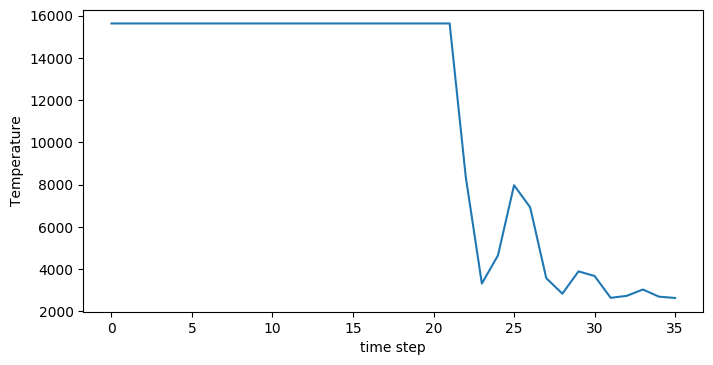

In [42]:
pyplot.figure(figsize=(8,4), dpi=100)
pyplot.plot(data[:,1])
pyplot.xlabel('time step')
pyplot.ylabel('Temperature')

**Tips on handling the ASE atoms object**   
Below are a couple of examples how to extract information from the atoms object.

In [28]:
at_configuration=ase.io.read("system.extxyz") # read atoms objects from file
box=at_configuration.get_cell() # simulation box parameters (3*3 matrix)
vol=at_configuration.get_volume() # volume of the simulation box
pos=at_configuration.get_positions() # atomic coordinates
N=len(at_configuration) # number of atoms
at_type=at_configuration.get_chemical_symbols() # atom_type of each atom

ASE provides several tools to analyse structural properties of configurations, if necessary modules are loaded (``from ase.geometry.analysis import Analysis``) e.g. to calculate radial distribution functions. For further help on how to use these features, check the manual.

## 9. Minimal working example

Below is a minimal example on performing a short MD simulation on a the NVT ensemple, using one-component Lennard-Jones. 

In [29]:
import hoomd
from hoomd import md
hoomd.context.initialize('--mode=cpu');

# Create a 10x10x10 simple cubic lattice of particles with type name A
hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.0, type_name='A'), n=10)

# Specify Lennard-Jones interactions between particle pairs
nl = md.nlist.cell()
lj = md.pair.lj(r_cut=3.0, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)

# Integrate at constant temperature
md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=4)

# Run for 10,000 time steps
hoomd.run(10e3)

notice(2): Group "all" created containing 1000 particles
notice(2): integrate.langevin/bd is using specified gamma values
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:04 | Step 10000 / 10000 | TPS 2136.22 | ETA 00:00:00
Average TPS: 2135.96
---------
-- Neighborlist stats:
918 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 49 / n_neigh_avg: 12.607
shortest rebuild period: 8
-- Cell list stats:
Dimension: 5, 5, 5
n_min    : 0 / n_max: 22 / n_avg: 8
** run complete **


## Computing a radial distribution function

This is a function (taken from the CH273 module) which computes the *g(r)*. Said function takes in input the following arguments: 
* **r**   = a numpy array containing the positions of all the particles
* **S**   = the length of the box (which is assumed to be square/cubic in 2/3D !!)
* **dr**  = the resolution in r. The smaller this value, the greater the resolution
* **dim** = the dimensionality of the system (2 or 3 D)

and can be call in this fashion: `rad_py, g_r_py = py_rdf(n_data, length, res_dr, 2)` so as to store *r* and *g(r)* into the `rad_py` and `g_r_py` arrays, respectively.

In [38]:
def py_rdf(r, S, dr, dim):
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram, absolute
    num_particles  = len(r)
    rMax           = S/2.0;
    edges          = arange(0., rMax + dr, dr)
    num_increments = len(edges) - 1
    g              = zeros(num_increments)
    radii          = zeros(num_increments)
    numberDensity  = len(r) / S**dim

    # Compute pairwise correlation for each particle
    for index in range(num_particles):

        d = 0.0
        for i in range(dim):
            dp = absolute(r[index,i] - r[:,i])
            mask = dp>S/2.0
            dp[mask] = S - dp[mask]
            d += dp*dp

        d = sqrt(d)
        d[index] = 2 * rMax

        (result, bins) = histogram(d, bins=edges, density=False)
        g += result

    g = g/(num_particles * numberDensity)

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 2D!
    if dim == 2:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (2.0 * pi * (rOuter-rInner)* radii[i])
    
    # Needed to compute the 3D g(r) (blue box)
    # Normalize the g(r) divinding by the g(r) of an ideal gas - in 3D!
    if dim == 3:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (4.0 * pi * (rOuter-rInner)* radii[i] * radii[i] )

    return (radii, g)

In [51]:
V=125*(10**30)/(1000*3000*6.022*10**23)
print(V)

69.19074504594266
